<a href="https://colab.research.google.com/github/DesTuu/LearningDeepLearning/blob/main/Full_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
# import itertools
# import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Convert MNIST Image into a Tensor of 4D (# of images, height, width, color channels)
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 152kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)

In [10]:
# for i, (X_train, y_train) in enumerate(train_loader):
#     # print(f"{i:2}. {X_train.shape} - {y_train.shape}")
#     # print(f"Label: {X_train}")
#     break

X_train, y_train = next(iter(train_loader))

In [11]:
X_train.shape

torch.Size([10, 1, 28, 28])

In [12]:
x = X_train.view(-1, 1, 28, 28)

In [13]:
x = F.relu(conv1(x))

In [14]:
x.shape

torch.Size([10, 6, 26, 26])

In [15]:
x = F.max_pool2d(x, 2, 2) # kernal 2x2

In [16]:
x.shape

torch.Size([10, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([10, 16, 11, 11])

In [19]:
x = F.max_pool2d(x, 2, 2)

In [20]:
x.shape

torch.Size([10, 16, 5, 5])

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
        # return F.log_softmax(x, dim=1)

In [22]:
torch.manual_seed(41)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [24]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.0360131673514843
Epoch: 0  Batch: 1200  Loss: 0.4388193190097809
Epoch: 0  Batch: 1800  Loss: 0.21528545022010803
Epoch: 0  Batch: 2400  Loss: 0.02980760857462883
Epoch: 0  Batch: 3000  Loss: 0.009968600235879421
Epoch: 0  Batch: 3600  Loss: 0.4835713505744934
Epoch: 0  Batch: 4200  Loss: 0.012093263678252697
Epoch: 0  Batch: 4800  Loss: 0.0041069998405873775
Epoch: 0  Batch: 5400  Loss: 0.05026329308748245
Epoch: 0  Batch: 6000  Loss: 0.004708246327936649
Epoch: 1  Batch: 600  Loss: 0.014619432389736176
Epoch: 1  Batch: 1200  Loss: 0.13881953060626984
Epoch: 1  Batch: 1800  Loss: 0.008404508233070374
Epoch: 1  Batch: 2400  Loss: 0.0034382990561425686
Epoch: 1  Batch: 3000  Loss: 0.14972397685050964
Epoch: 1  Batch: 3600  Loss: 0.08050362020730972
Epoch: 1  Batch: 4200  Loss: 0.0303109772503376
Epoch: 1  Batch: 4800  Loss: 0.00018229358829557896
Epoch: 1  Batch: 5400  Loss: 0.00011058537347707897
Epoch: 1  Batch: 6000  Loss: 0.13077576458454132
Epoch: 2  B

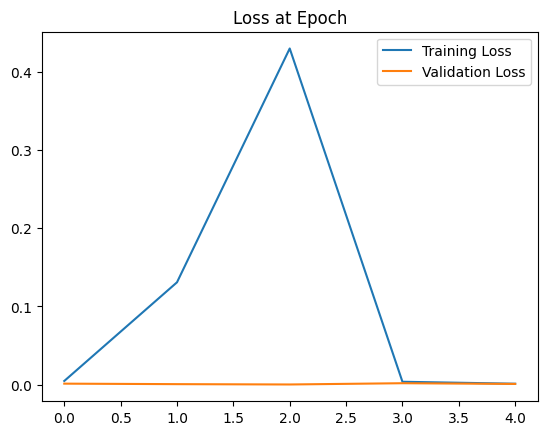

In [25]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

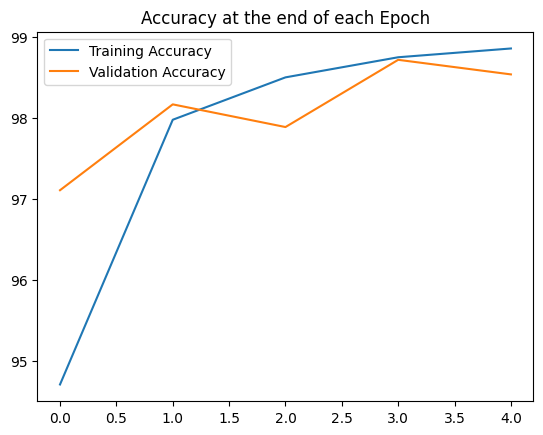

In [26]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [27]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [29]:
f"{correct.item()/len(test_data)*100}%"

'98.54%'

In [42]:
my_example1 = test_data[1997]
my_example2 = test_data[2424]
my_example1

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
my_example1[1], my_example2[1]

(3, 3)

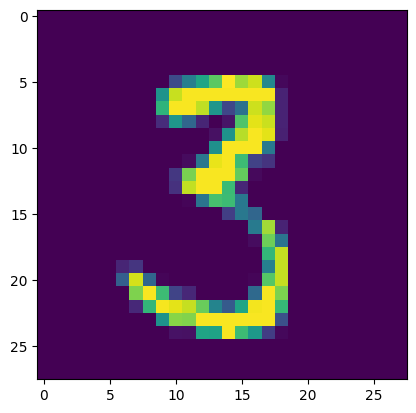

In [34]:
plt.imshow(my_example1[0].reshape(28,28))

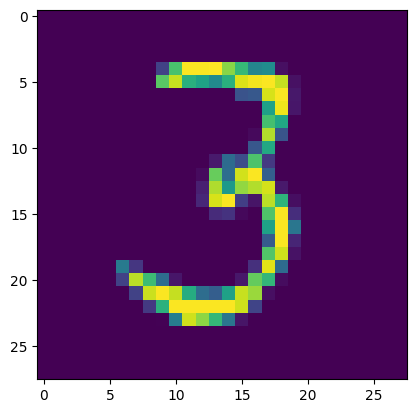

In [35]:
plt.imshow(my_example2[0].reshape(28,28))

In [39]:
with torch.no_grad():
  new_prediction1 = model(my_example1[0].view(1,1,28,28))
  new_prediction2 = model(my_example2[0].view(1,1,28,28))

In [40]:
new_prediction1

tensor([[-29.9510, -12.1343, -12.0345,   8.3609, -20.4226,  -8.9332, -25.2912,
         -12.6160,  -9.5384,  -9.2469]])

In [43]:
new_prediction1.argmax(), new_prediction2.argmax()

(tensor(3), tensor(3))